In [16]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable # Autograd: 자동 미분 수행, tape: 미분값들을 모두 저장, backward 때 사용
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # for data pre-processing
from torch.utils.data import Dataset, DataLoader

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
train_dataset = torchvision.datasets.FashionMNIST('', download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))

test_dataset = torchvision.datasets.FashionMNIST('', download=True,
                                                  train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [19]:
# fashion_mnist data를 메모리로 불러오기 위해
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

In [20]:
train_dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

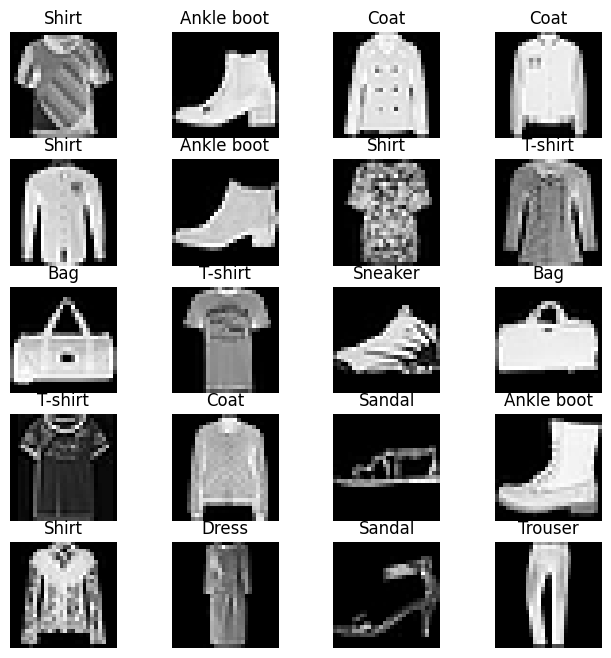

In [21]:
labels = { 0:'T-shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
          5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot' }


fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5

for i in range(1, columns*rows+1):
  img_xy = np.random.randint(len(train_dataset));
  img = train_dataset[img_xy][0][0,:,:]
  fig.add_subplot(rows, columns, i)
  plt.title(labels[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')

plt.show()

### DNN ver.


#### 함수: 특정 작업 수행을 위해 독립적으로 설계된 코드

✅ 함수의 call은 특정 작업만 수행할 뿐, 그 결과를 계속 사용하기 위해서는 어딘가에 따로 그 값을 저장해야 함. 즉 함수를 포함한 코드의 일부를 재사용하기 위해서는 해당 함수뿐만 아니라 데이터가 저정되는 변수까지도 관리되어야 함. ▶️ 이를 가능하게 하는 것이 **class**

In [22]:
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__() # FashionDNN class 상속
    self.fc1 = nn.Linear(in_features=784, out_features=256)
    self.drop = nn.Dropout(0.25) # 0.25의 비율로 tensor의 값이 0
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  # Forward Propagation
  def forward(self, input_data):
    out = input_data.view(-1, 784) # numpy의 reshape와 같은 역할
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out


In [23]:
learning_rate = 0.001
model = FashionDNN()
model.to(device) # 데이터도 동일한 장치 위에 있어야 함.

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
epochs = 5
cnt = 0

loss_list = []
iteration_list = []
acc_list = []

pred_list = []
labels_list = []

for epoch in range(epochs):
  for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device) # 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치에 있어야 함.

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    cnt += 1

    if not cnt % 50:
      total = 0
      correct = 0

      for images, lables in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        pred_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      acc_list.append(accuracy)

    if not cnt % 500:
      print(f'Iteration: {cnt}, Loss: {loss.data}, Accuracy: {accuracy}')